In [1]:
# Setup logging
from timeseria import logger
logger.setup(level='INFO')

Setting log level to "INFO"



# Timeseria quickstart

Timeseria is a data processing library which aims at making it easy to manipulate time series data and to build statistical and machine learning models on top of it.

Unlike common numerical and data analyisis frameworks, it is fully object-oriented and quite Pythonic. It adopts a strategy of implementing building blocks that can be easily composed together, and integrates a powerful plotting engine based on Dygraphs.

It comes with a built-in set of common operations (resampling, slotting, differencing etc.) and models (reconstruction, forecasting and anomaly detection) which can cover a variety of simple use-cases. Moreover, both custom operations and models can be easily plugged in.

Timeseria also addresses by design all those annoying things which are often left as an implementation detail but that actually cause wasting massive amounts of time - as handling data losses, non-uniform sampling rates, differences between time-slotted (aggregated) data and punctual observations, variable time units, timezones, DST changes and so on.

This is a quickstart, if you are looking for a more structured introduction, have a look at the [welcome notebook](https://github.com/sarusso/Timeseria-notebooks/blob/master/notebooks/Welcome.ipynb). Also the [reference documentation](https://timeseria.readthedocs.io) might be useful.

<br/>

## Load some data


Let's load some data: an indoor temperature winter dataset.

In [2]:
from timeseria import storages
DATASET_PATH = '/'.join(storages.__file__.split('/')[0:-1]) + '/tests/test_data/csv/'

temperature_timeseries = storages.CSVFileStorage(DATASET_PATH + 'temperature_winter.csv').get()

Let's have a look at the time series we just loaded:

In [3]:
temperature_timeseries

Time series of #14403 points at variable resolution (~600s), from point @ 1546477200.0 (2019-01-03 01:00:00+00:00) to point @ 1555550400.0 (2019-04-18 01:20:00+00:00)

Now plot the data, using Timeseria built-in plotting engine:

[INFO] timeseria.plots: Aggregating by "10" for improved plotting


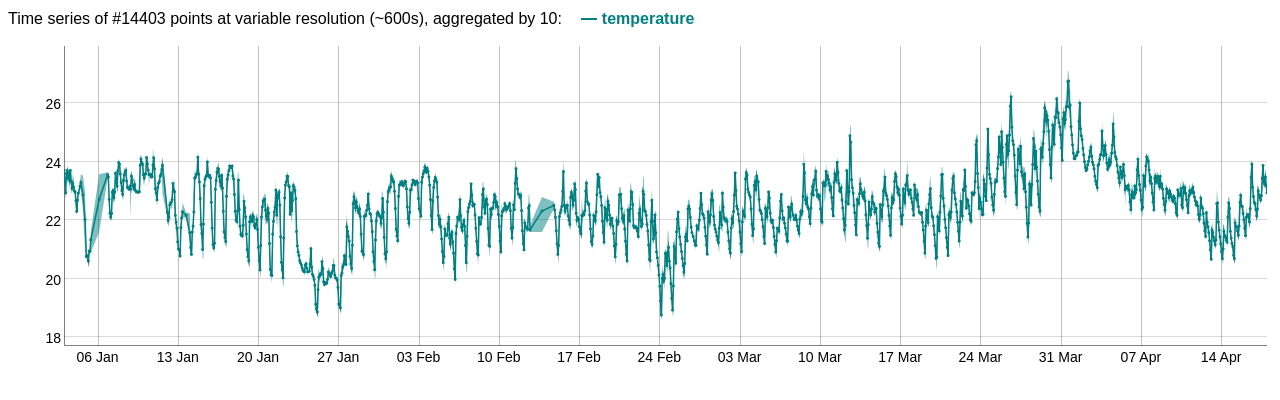

In [4]:
temperature_timeseries.plot()

In this plot, data has been aggregated by a factor of 10, and represented as a line chart plus an area chart (for the minimum and maximum values). In this way you can plot even millions of data points wihtout slowing down the plot engine or crashing your browser, without loosing much information about peaks and spikes.


***Note:*** *these plots are rendered as non-interactive, in image format, using an environment-level configuration variable (not covered here) so that they can be displayed on GitHub and when loading the notebook. If you re-run this notebook in your local environment, the plots will become interactive. To get back to non-interactive plots, add the `interactive=True` switch to the `plot()` function (which will require to automatically download a Chromium headless engine for rendering the plot as an image).*

<br/>

## Resample (and make data uniform)

Now resample the time series at one hour sampling interval, also making data uniform and equally spaced over time. Gaps are filled by linear interpolation (the default interpolation method for the resampling) and the "data loss" index is added as data point attribute.

In [5]:
temperature_timeseries = temperature_timeseries.resample('1h')

[INFO] timeseria.transformations: Using auto-detected sampling interval: 600.0s
[INFO] timeseria.transformations: Resampled 14403 DataTimePoints in 2521 DataTimePoints


In [6]:
temperature_timeseries

Time series of #2521 points at 1h resolution, from point @ 1546477200.0 (2019-01-03 01:00:00+00:00) to point @ 1555549200.0 (2019-04-18 01:00:00+00:00)

In [7]:
temperature_timeseries[58].data_loss

0.25

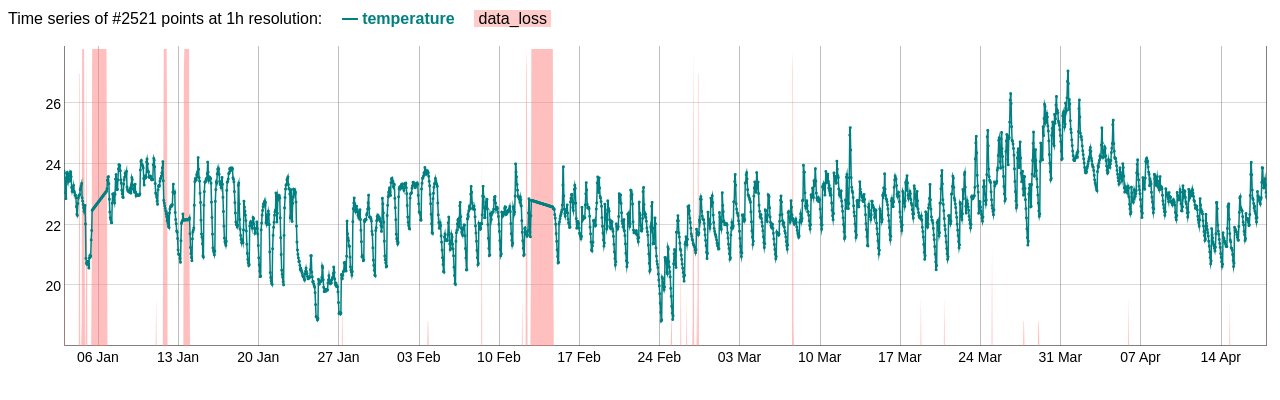

In [8]:
temperature_timeseries.plot()

<br/>

## Reconstruct missing data

Train a periodic average-based data reconstruction model. Fit the model on about 80% of the data and test on the rest, on 6, 12, and 24 hours gaps, limiting the evaluation to 100 samples per step to speed up the process:

In [9]:
from timeseria.models import PeriodicAverageReconstructor

In [10]:
paverage_reconstructor = PeriodicAverageReconstructor()
paverage_reconstructor.fit(temperature_timeseries[0:2000])
paverage_reconstructor.evaluate(temperature_timeseries[2000:], steps=[6,12,24], limit=100)

[INFO] timeseria.models.reconstructors: Detected periodicity: 24x 1h
[INFO] timeseria.models.reconstructors: Will evaluate model for [6, 12, 24] steps with metrics ['RMSE', 'MAE']


{'RMSE': 0.7125619042757325, 'MAE': 0.5803696784300851}

Use the reconstruction model to reconstruct missing data points (100% data loss). A "data_reconstructed" index is added as data points attribute.

In [11]:
temperature_timeseries = paverage_reconstructor.apply(temperature_timeseries)

...and plot:

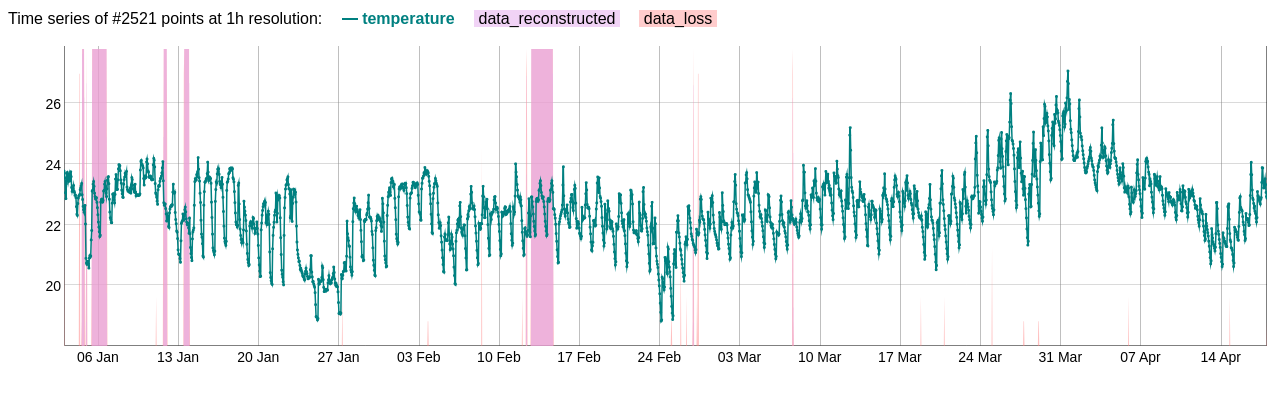

In [12]:
temperature_timeseries.plot()

<br />

## Three days hourly temperature forecast

Use a LSTM neural network model to to forecast three days of temperatures, but before fitting run a cross validation on three rounds to get an idea about the accuracy to expect, limiting the evaluation to 100 samples per step to speed up the process:

In [13]:
from timeseria.models import LSTMForecaster

In [14]:
LSTM_forecaster = LSTMForecaster(window=12, neurons=64, features=['values', 'diffs', 'hours'])
LSTM_forecaster.cross_validate(temperature_timeseries, rounds=3)

[INFO] timeseria.models.base: Cross validation round #1 of 3: validate from 1546477200.0 (2019-01-03 01:00:00+00:00) to 1549501200.0 (2019-02-07 01:00:00+00:00), fit on the rest.
[INFO] timeseria.models.forecasters: Will evaluate model for [1, 2, 3] steps with metrics ['RMSE', 'MAE']
[INFO] timeseria.models.base: Cross validation round #2 of 3: validate from 1549501200.0 (2019-02-07 01:00:00+00:00) to 1552525200.0 (2019-03-14 01:00:00+00:00), fit on the rest.
[INFO] timeseria.models.forecasters: Will evaluate model for [1, 2, 3] steps with metrics ['RMSE', 'MAE']
[INFO] timeseria.models.base: Cross validation round #3 of 3: validate from 1552525200.0 (2019-03-14 01:00:00+00:00) to 1555549200.0 (2019-04-18 01:00:00+00:00), fit on the rest.
[INFO] timeseria.models.forecasters: Will evaluate model for [1, 2, 3] steps with metrics ['RMSE', 'MAE']


{'RMSE_avg': 0.37469714044428676,
 'RMSE_stdev': 0.022163332902633455,
 'MAE_avg': 0.2768478579834633,
 'MAE_stdev': 0.014615993860607362}

Now fit, apply for 72 steps ahead, and plot:

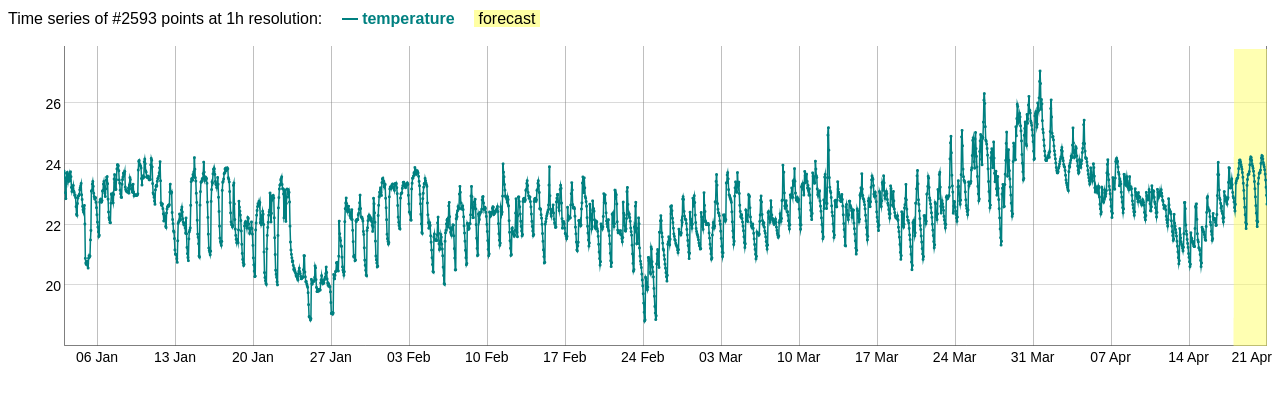

In [15]:
LSTM_forecaster.fit(temperature_timeseries)
LSTM_forecaster.apply(temperature_timeseries,n=72).plot(indexes=['forecast'])


<br />

## Run an anomaly detection model

Use the periodic average anomaly detection model, which will consider a data point value an anomaly if too far from its periodic average. This will add an "anomaly" index as data points attibute.

In [16]:
from timeseria.models import PeriodicAverageAnomalyDetector
paverage_anomaly_detector = PeriodicAverageAnomalyDetector()
paverage_anomaly_detector.fit(temperature_timeseries, stdevs=5)

[INFO] timeseria.models.forecasters: Detected periodicity: 24x 1h
[INFO] timeseria.models.forecasters: Using a window of "24"
[INFO] timeseria.models.anomaly_detectors: Using 5 standard deviations as anomaly threshold: 1.8218057469668172


Apply and plot, but show only the "anomaly" index to improve plot readability:

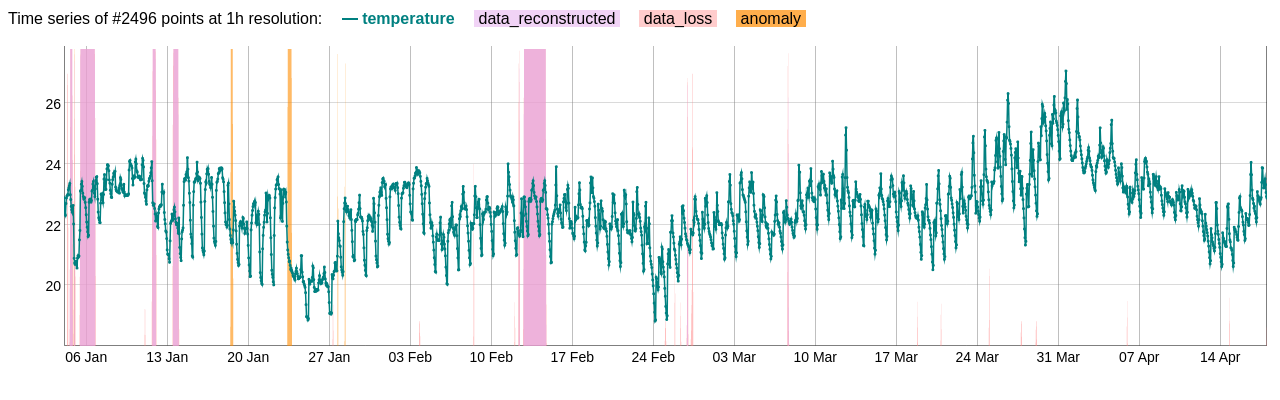

In [17]:
paverage_anomaly_detector.apply(temperature_timeseries).plot()

<br/>

## Altogether

Apply again both models, but this time on the same time series, and plot:

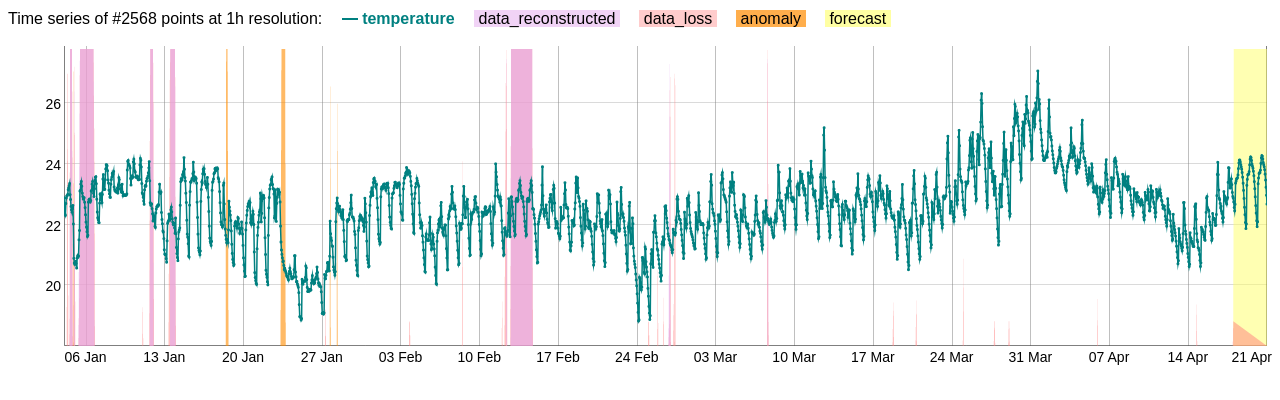

In [18]:
anoamaly_temperature_timeseries = paverage_anomaly_detector.apply(temperature_timeseries)
forecast_and_anomaly_temperature_timeseries = LSTM_forecaster.apply(anoamaly_temperature_timeseries, n=72)
forecast_and_anomaly_temperature_timeseries.plot()

<br/>

## Move to daily data

Slot the time series into 1-day slots, also computing the min and max operations besideds the default average one, but change the timezone before to get the right daily aggregates and to properly take into account the DST change. Slotting in days is indeed different than slotting in 24 hours, they are just two different time units: the first is variable, the second is fixed.

[INFO] timeseria.transformations: Using auto-detected sampling interval: 3600.0s
[INFO] timeseria.transformations: Slotted 2567 DataTimePoints in 106 DataTimeSlots


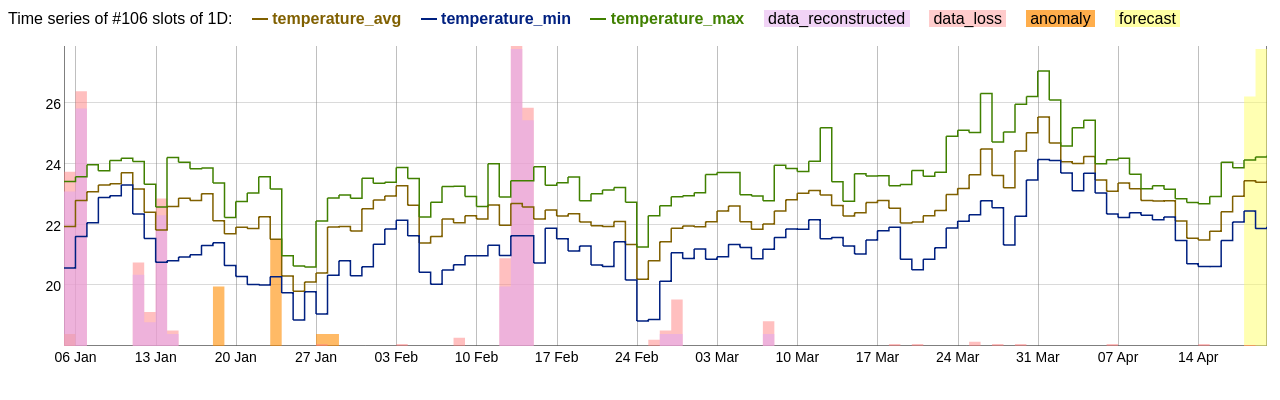

In [19]:
forecast_and_anomaly_temperature_timeseries.change_timezone('Europe/Rome')
from timeseria.operations import min, max
forecast_and_anomaly_temperature_timeseries.slot(unit='1D', extra_operations=[min,max]).plot()

<br/>

## Next steps

You can have a look at the [welcome notebook](https://github.com/sarusso/Timeseria-notebooks/blob/master/notebooks/Welcome.ipynb), which provides a more structured introduction on Timeseria datastructures and their philosophy, as well as practical examples on both built-in and custom models and operations.


You can also try yourself by running the Timeseria Docker container, wich comes with this example notebooks repository pre-installed:

    docker run -it -p8888:8888 sarusso/timeseria


Or, you can give it a try in your own projects:

    pip install timeseria
    

..and you can of course contribute! :)
<br/>
<br/>


